## EXERCISE 1

Create the following causal network to verify that the red path is indeed a backdor path using the Causal Graphical Models library

<img src='https://drive.google.com/uc?id=18HUhYGI9Bd2eR87jW_1AdQyCZZBOtBfD'>

In [ ]:
!pip install causalgraphicalmodels
!sed -i 's/collections/collections.abc/g' /usr/local/lib/python3.10/dist-packages/causalgraphicalmodels/cgm.py
from causalgraphicalmodels import CausalGraphicalModel

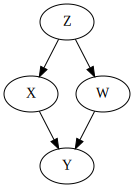

In [ ]:
g1 = CausalGraphicalModel(
    nodes = ["Z", "W", "X", "Y"],
    edges = [("Z", "W"),
             ("Z", "X"),
             ("X", "Y"),
             ("W", "Y")]
)

g1.draw()

Is there any backdoor path?

In [ ]:
p1 = g1.get_all_backdoor_paths("X", "Y")

print(p1)

[['X', 'Z', 'W', 'Y']]


The red path is actually a backdoor path

## EXERCISE 2

Create the following causal network using the Causal Graphical Models library and find out all the possible sets that satisfy the backdoor criterion.

<img src='https://drive.google.com/uc?id=1rY42DmXV7TpRm7rt5N7m78w30VmyvotC'>



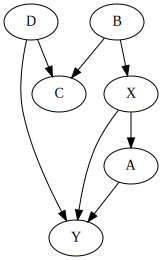

In [ ]:
g2 = CausalGraphicalModel(
    nodes = ["A", "X", "Y", "B", "C", "D"],
    edges = [("X", "A"),
             ("X", "Y"),
             ("A", "Y"),
             ("B", "X"),
             ("B", "C"),
             ("D", "C"),
             ("D", "Y")]
)

g2.draw()

All sets that satisfy the backdoor criterion

In [ ]:
g2.get_all_backdoor_paths("X", "Y")

[['X', 'B', 'C', 'D', 'Y']]

In [ ]:
g2.is_valid_backdoor_adjustment_set("X", "Y", {"B", "C", "D"})

True

## EXERCISE 3

Create the following causal network using the Causal Graphical Models library and find out all the valid sets for applying the front-door criterion.

<img src='https://drive.google.com/uc?id=1Z6YiKMDVKPLFM5luY_pT78ovSpWH-Ibd'>


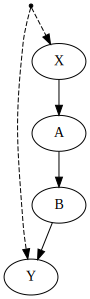

In [ ]:
g3 = CausalGraphicalModel(
    nodes = ['X', 'A', 'B', 'Y'],
    edges = [
        ('X','A'),
        ('A', 'B'),
        ('B', 'Y')
    ],
    latent_edges = [
    ('X', 'Y')
    ]

)

g3.draw()

In [ ]:
g3.get_all_frontdoor_adjustment_sets('X', 'Y')

frozenset({frozenset({'A'}), frozenset({'B'}), frozenset({'A', 'B'})})

## EXERCISE 4

Create the following causal network using the Causal Graphical Models library and find out all the valid sets for applying the front-door criterion.

<img src='https://drive.google.com/uc?id=1lK3HZktVYCsJrDzZYEB0uQhL-DxWACcP'>

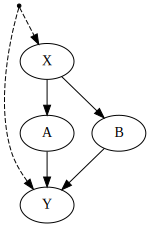

In [ ]:
g4 = CausalGraphicalModel(
    nodes = ['X', 'A', 'B', 'Y'],
    edges = [
        ('X','A'),
        ('X', 'B'),
        ('A', 'Y'),
        ('B', 'Y')
    ],
    latent_edges = [
    ('X', 'Y')
    ]

)
g4.draw()

In [ ]:
g4.get_all_frontdoor_adjustment_sets('X', 'Y')

frozenset({frozenset({'A', 'B'})})

## EXERCISE 5

Consider again the smoking example, for which we have the following data from an hypothetical experiment with 400 smokers and 400 non-smokers:

<img src='https://drive.google.com/uc?id=1RvqtRMF4auVECmSniLFm5yOCq3ykmT-0'>

Write a Python program implementing the front-door adjustment and compute the causal effect of smoking on lung cancer is $P(y | do(x))$.

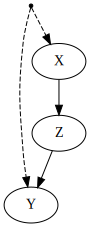

In [ ]:
smoke = CausalGraphicalModel(
    nodes = ['X', 'Y', 'Z'],
    edges = [
        ('X','Z'),
        ('Z', 'Y')
    ],
    latent_edges = [
    ('X', 'Y')
    ]

)

smoke.draw()

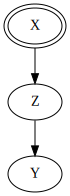

In [ ]:
smoke_do = smoke.do("X")

smoke_do.draw()

In [ ]:
print(smoke_do.get_distribution())

P(Z|do(X))P(Y|Z)


Now I have to find the sets of vars $S$ that satisfy the backdoor criterion to compute the front-door adjustment formula

$$
P(y|do(x)) = \sum_{S} P(y|x,s) P(s)
$$


In [ ]:
smoke_do.get_all_frontdoor_adjustment_sets('X', 'Y')

frozenset({frozenset({'Z'})})

So, we must compute
$$
P(y|do(x)) = \sum_{z} P(z|x) \sum_{x'} P(y|z, x') P(x')
$$

Let's get all the sample probabilities!

In [ ]:
import numpy as np

t , f = 0, 1

P_X = np.array([0.5, 0.5])
P_Z_X = np.array([[0.95, 0.05], [0.05, 0.95]])
P_Y_ZX = np.array([[[0.15, 0.95], [0.10, 0.90]], [[0.85, 0.05], [0.90, 0.1]]])


And let's compute the probability requested, which can be decomposed as follows

$$
P(y|do(x)) = P(z|x) \left[P(y|z, x') P(x') + P(y|z, \neg x') P(\neg x') \right] +
P(\neg z|x) \left[P(y|\neg z, x') P(x') + P(y|\neg z, \neg x') P(\neg x') \right]
$$

where $x' = do(x) $


In [ ]:
pydox = (
  P_Z_X[t,t] * ((P_Y_ZX[t,t,t] * P_X[t])+ ((P_Y_ZX[t,t,f] * P_X[f]))) +
  P_Z_X[f,t] * ((P_Y_ZX[t,f,t] * P_X[t])+ ((P_Y_ZX[t,f,f] * P_X[f])))
)

print(pydox)

0.5475


There is a faster way to get the prob with python decomposing the sum:

$$
\phi_{x'} =  \sum_{x'} P(y|z, x') P(x')
$$

In [ ]:
Phi_X = P_Y_ZX[:, :, t] * P_X[t] +  P_Y_ZX[:, :, f] * P_X[f]
print(Phi_X)

[[0.55 0.5 ]
 [0.45 0.5 ]]


Then
$$
\phi_z = \sum_{z} P(z|x) \phi_{x'}
$$

In [ ]:
Phi_Z = P_Z_X[:, t] * Phi_X[:, t] + P_Z_X[:, f] * Phi_X[:, f]
print(Phi_Z)

[0.5475 0.4975]
